In [1]:
import numpy as np
from sklearn.svm import SVR
import pandas as pd
import matplotlib.pyplot as plt

In [44]:
batting_data_path = 'bsb_ref.csv'
# INFO:
# 101,332 Players with up to 20 features each (exluding year, including team)
# if metric not reported for player, set to 0.0 by default

df = pd.read_csv(batting_data_path)
df = df.fillna(0) # fixing this could really help with results potentially
df_recent_players = df[df.year_ID >= 1975] 
df_probably_not_pitchers = df_recent_players[df_recent_players['PA'] >= 50]

players = list(set(df_probably_not_pitchers['name_common'])) # just a set of all players

In [140]:
# players with both 2016 and 2017
# just go through list of players that are probably not pitchers 
# append the rows from 2016/2017 years respectively
# there are some years with multiple seasons.. to account for that, i just did "head(1)"
df_2016 = pd.DataFrame(columns=df_recent_players.columns)
df_2017 = pd.DataFrame(columns=df_recent_players.columns)
for player in players:
    rows_per_player = df_recent_players[df_recent_players['name_common'] == player]
    if 2016 in rows_per_player.values and 2017 in rows_per_player.values:
        df_2016 = df_2016.append(rows_per_player[rows_per_player['year_ID'] == 2016].head(1))
        df_2017 = df_2017.append(rows_per_player[rows_per_player['year_ID'] == 2017].head(1))

 

In [141]:
df_2017.describe

<bound method NDFrame.describe of                name_common   age    mlb_ID  player_ID year_ID team_ID  \
91195          Denard Span  33.0  452655.0   spande01    2017     SFG   
53450         Juan Lagares  28.0  501571.0  lagarju01    2017     NYM   
60558      Victor Martinez  38.0  400121.0  martivi01    2017     DET   
50366             Ty Kelly  28.0  571841.0  kellyty01    2017     NYM   
2797            Cody Asche  27.0  605125.0  ascheco01    2017     CHW   
95441         Ruben Tejada  27.0  514913.0  tejadru01    2017     BAL   
75026         Wily Peralta  28.0  503449.0  peralwi01    2017     MIL   
18317          Gerrit Cole  26.0  543037.0   colege01    2017     PIT   
64875    Will Middlebrooks  28.0  519025.0  middlwi01    2017     TEX   
42316      Cesar Hernandez  27.0  514917.0  hernace02    2017     PHI   
73072        Marcell Ozuna  26.0  542303.0  ozunama01    2017     MIA   
3645          Homer Bailey  31.0  456701.0  baileho02    2017     CIN   
16125   Francisco

In [142]:
# separate test and train data
# we could experiment here with removing features/PCA
train, test = train_test_split(df_2016, test_size=0.25, random_state=99)

x_train = train[['PA', 'G', 'Inn', 'runs_bat', 'runs_br', 'runs_dp', 'runs_field', 
                                       'runs_infield', 'runs_outfield', 'runs_catcher', 'runs_good_plays',
                                       'runs_defense', 'runs_position', 'runs_position_p', 'runs_replacement',
                                        'runs_above_rep', 'runs_above_avg', 'runs_above_avg_off', 'runs_above_avg_def',
                                       'WAA', 'WAA_off', 'WAA_def', 'WAR', 'WAR_def', 'WAR_off', 'WAR_rep',
                                       'salary', 'teamRpG', 'oppRpG', 'oppRpPA_rep', 'oppRpG_rep',
                                       'pyth_exponent', 'pyth_exponent_rep', 'waa_win_perc', 'waa_win_perc_off',
                                       'waa_win_perc_def', 'waa_win_perc_rep', 'TOB_lg', 'TB_lg']]
y_train = train[['OPS_plus']]

x_test = test[['PA', 'G', 'Inn', 'runs_bat', 'runs_br', 'runs_dp', 'runs_field', 
                                       'runs_infield', 'runs_outfield', 'runs_catcher', 'runs_good_plays',
                                       'runs_defense', 'runs_position', 'runs_position_p', 'runs_replacement',
                                        'runs_above_rep', 'runs_above_avg', 'runs_above_avg_off', 'runs_above_avg_def',
                                       'WAA', 'WAA_off', 'WAA_def', 'WAR', 'WAR_def', 'WAR_off', 'WAR_rep',
                                       'salary', 'teamRpG', 'oppRpG', 'oppRpPA_rep', 'oppRpG_rep',
                                       'pyth_exponent', 'pyth_exponent_rep', 'waa_win_perc', 'waa_win_perc_off',
                                       'waa_win_perc_def', 'waa_win_perc_rep', 'TOB_lg', 'TB_lg']]
y_test = test[['OPS_plus']]

In [143]:
# Create the Support Vector Regression model

svr = SVR(kernel='rbf', gamma=1e-3, C=150, epsilon=0.3)
svr.fit(x_train, y_train.values.ravel())

y_svr_pred = svr.predict(x_test)

print('Score: %.3f' % svr.score(x_train, y_train))
print("Mean squared error: %.3f" % mean_squared_error(y_test, y_svr_pred))
print('Mean Absolute error: %.3f' % mean_absolute_error(y_test, y_svr_pred))
print('Variance score: %.3f' % r2_score(y_test, y_svr_pred))

Score: 0.911
Mean squared error: 3990.329
Mean Absolute error: 44.090
Variance score: 0.080


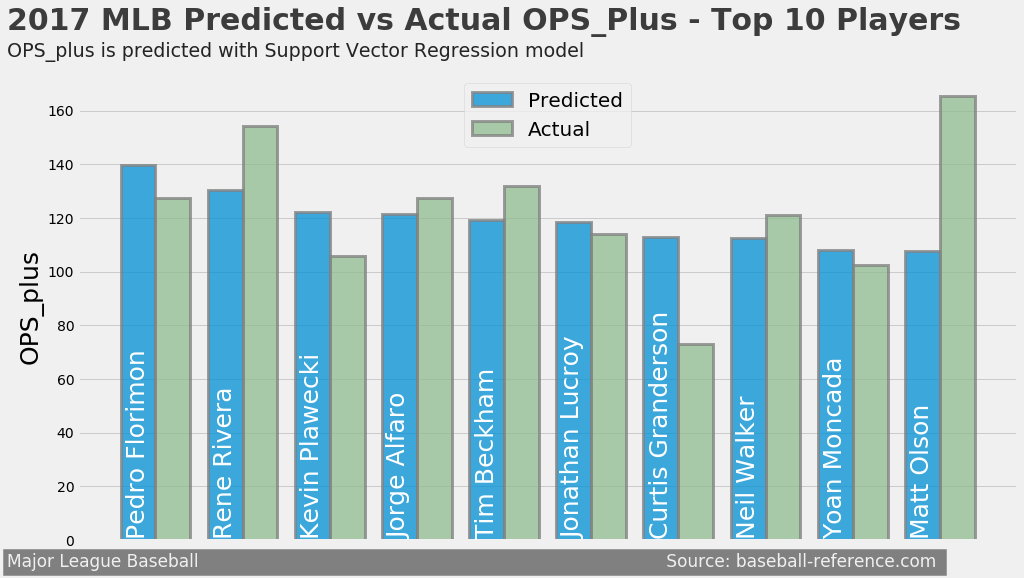

In [145]:
# Predict OPS_plus using Support Vector Regression Model

svr_new = df_2017[['PA', 'G', 'Inn', 'runs_bat', 'runs_br', 'runs_dp', 'runs_field', 
                                       'runs_infield', 'runs_outfield', 'runs_catcher', 'runs_good_plays',
                                       'runs_defense', 'runs_position', 'runs_position_p', 'runs_replacement',
                                        'runs_above_rep', 'runs_above_avg', 'runs_above_avg_off', 'runs_above_avg_def',
                                       'WAA', 'WAA_off', 'WAA_def', 'WAR', 'WAR_def', 'WAR_off', 'WAR_rep',
                                       'salary', 'teamRpG', 'oppRpG', 'oppRpPA_rep', 'oppRpG_rep',
                                       'pyth_exponent', 'pyth_exponent_rep', 'waa_win_perc', 'waa_win_perc_off',
                                       'waa_win_perc_def', 'waa_win_perc_rep', 'TOB_lg', 'TB_lg']]

svr_pred_2017 = svr.predict(svr_new)


svr_names = df_2017.iloc[:, 0]

b = []
for i, j in zip(svr_pred_2017, svr_names):
    b.append({'OPS_plus_pred':i,'name_common':j})

ops_2017 = df_2017[['name_common', 'OPS_plus']]


svr_ops_plus = pd.DataFrame(b)
svr_ops_plus['OPS_plus_pred'] = round(svr_ops_plus['OPS_plus_pred'].astype(float),2)

svr_ops_plus = svr_ops_plus.sort_values([('OPS_plus_pred')], ascending = False).reset_index(drop=True).head(10)
svr_ops_plus = svr_ops_plus.merge(ops_2017, on = 'name_common', how = 'inner')

pos = np.arange(len(svr_ops_plus['OPS_plus_pred']))

plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize = (15,8))
plt.bar(pos, svr_ops_plus['OPS_plus_pred'], width = 0.4, alpha = 0.75, edgecolor = 'gray', linewidth = 3, label = 'Predicted')
plt.bar(pos + 0.4, svr_ops_plus['OPS_plus'], width = 0.4, alpha = 0.75, edgecolor = 'gray', linewidth = 3,label = 'Actual',color = 'darkseagreen')
for i in pos:
    plt.text(pos[i], 0.5, s = svr_ops_plus['name_common'][i],ha='center', va='bottom', rotation = 'vertical',color = 'white', size = 25)
plt.text(x = -1.5, y = 190, s = '2017 MLB Predicted vs Actual OPS_Plus - Top 10 Players',fontsize = 30, weight = 'bold', alpha = .75)
plt.text(x = -1.5, y = 180, s = 'OPS_plus is predicted with Support Vector Regression model',fontsize = 19, alpha = .85)
plt.text(x = -1.5, y = -10, s = 'Major League Baseball                                                                                       Source: baseball-reference.com ', fontsize = 17,color = '#f0f0f0', backgroundcolor = 'grey')
plt.xticks([],[])
plt.legend(prop={'size': 20})
ax.set_ylabel('OPS_plus', size = 25);